In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import seaborn as sns, pandas as pd, numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures, PowerTransformer
from sklearn.metrics import make_scorer,f1_score,accuracy_score,confusion_matrix,roc_auc_score,roc_curve, recall_score,precision_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, NuSVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, kruskal,chi2_contingency

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE 
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours, NeighbourhoodCleaningRule, OneSidedSelection



def minha_metrica(y_true, y_pred):
    threshold = 0.5  # Defina o threshold desejado
    

    # Calcule o true positive rate para o threshold dado
    tp = np.sum((y_true == 1) & (y_pred >= threshold))
    fn = np.sum((y_true == 1) & (y_pred < threshold))
    tpr = tp / (tp + fn)

    # Calcule o true negative rate para o threshold dado
    tn = np.sum((y_true == 0) & (y_pred < threshold))
    fp = np.sum((y_true == 0) & (y_pred >= threshold))
    tnr = tn / (tn + fp)

    # Calcule o produto dos passos 1 e 2
    product = tpr * tnr

    # Retorne a raiz quadrada do passo 3
    return np.sqrt(product)

def minha_metrica_c(y_true, y_pred,threshold = 0.5):
    

    # Calcule o true positive rate para o threshold dado
    tp = np.sum((y_true == 1) & (y_pred >= threshold))
    fn = np.sum((y_true == 1) & (y_pred < threshold))
    tpr = tp / (tp + fn)

    # Calcule o true negative rate para o threshold dado
    tn = np.sum((y_true == 0) & (y_pred < threshold))
    fp = np.sum((y_true == 0) & (y_pred >= threshold))
    tnr = tn / (tn + fp)

    # Calcule o produto dos passos 1 e 2
    product = tpr * tnr

    # Retorne a raiz quadrada do passo 3
    return np.sqrt(product)

def get_scores(y_true_tr,y_pred_tr,y_true_ts,y_pred_ts,scorers=["roc_auc_score","accuracy_score","precision_score","recall_score","f1_score"]):
    nomes, vtest,vtrain = [],[],[]

    fpr, tpr, thresholds = roc_curve(y_true_tr, y_pred_tr)
    distances = (fpr - 0)**2 + (tpr - 1)**2
    index = distances.argmin()
    corte = thresholds[index]
    fprts, tprts, thresholdsts = roc_curve(y_true_ts, y_pred_ts)

    for sc in scorers:
        if sc.__name__ in ["roc_auc_curve"]:
            vtest.append(sc(y_true_ts,y_pred_ts))
            vtrain.append(sc(y_true_tr,y_pred_tr))
            nomes.append(sc.__name__)
        elif sc.__name__ in ["minha_metrica_c"]:
            vtest.append(sc(y_true_ts, y_pred_ts,threshold = corte))
            vtrain.append(sc(y_true_tr, y_pred_tr,threshold = corte))
            nomes.append(sc.__name__)
        else:
            vtest.append(sc(y_true_ts,y_pred_ts>=corte))
            vtrain.append(sc(y_true_tr,y_pred_tr>=corte))
            nomes.append(sc.__name__)    
    
    metricas = pd.DataFrame({"metrica":nomes,"valor no treino":vtrain,"valor no teste":vtest})
    roc_curve_train = {"fpr":fpr,"tpr":tpr,"thresholds":thresholds,"corte":corte} 
    roc_curve_test = {"fpr":fprts,"tpr":tprts,"thresholds":thresholdsts}
    cm = confusion_matrix(y_pred=y_pred_ts>=corte,y_true=y_true_ts)
    cm = pd.DataFrame({"pred_0":[cm[0][0],cm[1][0]],"pred_1":[cm[0][1],cm[1][1]]},index=["true 0","true_1"])
    res = {"metricas":metricas,"roc_curve_train":roc_curve_train,"roc_curve_test":roc_curve_test,"melhor":[fpr[index],tpr[index],corte],"confusion_matrix":cm}
    return res

def meu_enconder(data,target):
    data_train,data_test = train_test_split(data,test_size=0.2,stratify=data[target])
    for cl in data.columns[:-1]:
        if data[cl].dtypes==np.object0:
            contagemp = data_train.groupby(cl)[target].value_counts(normalize=True).unstack().fillna(0)
            idx = contagemp.sort_values(by=1,ascending=False).index
            mapeamento = {v:i for i,v in enumerate(idx)} 
            data_train[cl] = data_train[cl].map(mapeamento).astype(int)
            data_test[cl] = data_test[cl].map(mapeamento).astype(int)
    return data_train,data_test

def meu_enconder2(data,target):
    for cl in data.columns[:-1]:
        if data[cl].dtypes==np.object0:
            contagemp = data.groupby(cl)[target].value_counts(normalize=True).unstack().fillna(0)
            idx = contagemp.sort_values(by=1,ascending=False).index
            mapeamento = {v:i for i,v in enumerate(idx)} 
            data[cl] = data[cl].map(mapeamento).astype(int)
    return data

In [ ]:
data = pd.read_csv("dados_hospital.csv", sep=',')
data.dropna(inplace=True)
target = 'no_show'
mapeamento = {'SIM': 0, 'NÃO': 1}
data[target] = data[target].map(mapeamento).astype(int)
data = data[data["distance"]<1000]
original_columns = list(data.columns)

for cl in original_columns[:-1]:
    if data[cl].dtypes in [np.int64,np.int32,np.float64]:
        categories = pd.qcut(data[cl],10,duplicates='drop')
        labels, _ = pd.factorize(categories, sort=True)
        data[f"{cl}_cat"] = labels

data_train,data_test = train_test_split(data,test_size=0.2, random_state=42,stratify=data[target])

In [ ]:
mapas = {} 
continuousvar = []
categoricalvar = []

for cl in original_columns[:-1]:
    if data[cl].dtypes==np.object0:
        categoricalvar.append(cl)
        contagemp = data_train.groupby(cl)[target].value_counts(normalize=True).unstack().fillna(0)
        idx = contagemp.sort_values(by=1,ascending=False).index
        mapeamento = {v:i for i,v in enumerate(idx)} 
        mapas[cl] = [v for v in idx]
        data_train[cl] = data_train[cl].map(mapeamento).astype(int)
        data_test[cl] = data_test[cl].map(mapeamento).astype(int)
    elif data[cl].dtypes==np.int64:
        continuousvar.append(cl)


In [ ]:
var_cat = ['age_cat', 'distance_cat', 'lead_time_cat',
       'no_cons_scheduled_previous_year_cat', 'no_ns_cons_previous_year_cat',
       'no_exa_scheduled_previous_year_cat', 'no_ns_exa_previous_year_cat']
for cl in var_cat:
    contagemp = data_train.groupby(cl)[target].value_counts(normalize=True).unstack().fillna(0)
    idx = contagemp.sort_values(by=1,ascending=False).index
    mapeamento = {v:i for i,v in enumerate(idx)} 
    data_train[f"{cl}_cat2"] = data_train[cl].map(mapeamento).astype(int)
    data_test[f"{cl}_cat2"] = data_test[cl].map(mapeamento).astype(int)


In [ ]:
pval,tval,sigval = [],[],[]
for cl in original_columns[:-1]:
    if cl in categoricalvar:
        contingency_table = pd.crosstab(data_train[cl], data_train[target])
        chi2, p, _, _ = chi2_contingency(contingency_table)
        pval.append(p)
        tval.append(chi2)
        sigval.append(p<0.1)
    else:
        groups = []
        for category, group_data in data_train.groupby(cl)[target]:
            groups.append(group_data)
        f_statistic, p = kruskal(*groups)
        pval.append(p)
        tval.append(f_statistic)
        sigval.append(p<0.1)
significantvar = list([original_columns[i] for i,v in enumerate(sigval) if v])
stats = pd.DataFrame({"variable":original_columns[:-1],"test-value":tval,"p-value":pval,"significance":sigval})
stats[stats["significance"]==True]


In [ ]:
fig,ax = plt.subplots(3,3)
ax = ax.flatten()
i = 0
for cl in significantvar:
    sns.histplot(x=cl,data=data_train,ax=ax[i])
    i = i+1
plt.tight_layout()
plt.show()

In [ ]:
fig,ax = plt.subplots(3,2)
ax = ax.flatten()
i = 0
for cl in categoricalvar:
    if cl in significantvar:
        contagemp = data_train.groupby(cl)[target].value_counts(normalize=True).unstack().fillna(0)
        sns.scatterplot(x=cl,y=1,data=contagemp,ax=ax[i])
        i = i+1

plt.tight_layout()
plt.show()

In [ ]:
fig,ax = plt.subplots(3,2)
ax = ax.flatten()
i = 0
for cl in continuousvar:
    if cl in significantvar:
        contagemp = data_train.groupby(f"{cl}_cat")[target].value_counts(normalize=True).unstack().fillna(0)
        sns.scatterplot(x=f"{cl}_cat",y=1,data=contagemp,ax=ax[i],color="red")
        sns.lineplot(x=f"{cl}_cat",y=1,data=contagemp,ax=ax[i],linestyle='dashed')
        i = i+1

plt.tight_layout()
plt.show()

In [ ]:
cls = "age_cat"
grau = 2
contagemp = data_train.groupby(cls)[target].value_counts(normalize=True).unstack().fillna(0)
aa = np.polyfit(np.array(contagemp.index),np.array(contagemp[1]),grau)
xxp = np.array(contagemp.index)
yyp  = np.sum([par*xxp**(grau-i) for i,par in enumerate(aa)],axis=0)
sns.scatterplot(x=cls,y=1,data=contagemp,color="red")
sns.lineplot(x=cls,y=1,data=contagemp,linestyle='dashed')
sns.lineplot(x=xxp,y=yyp)

data_train["age_2"] = np.sum([par*data_train["age"]**(grau-i) for i,par in enumerate(aa)],axis=0)
data_test["age_2"] = np.sum([par*data_test["age"]**(grau-i) for i,par in enumerate(aa)],axis=0)

cls = "distance_cat"
grau = 2
contagemp = data_train.groupby(cls)[target].value_counts(normalize=True).unstack().fillna(0)
aa = np.polyfit(np.array(contagemp.index),np.array(contagemp[1]),grau)
xxp = np.array(contagemp.index)
yyp  = np.sum([par*xxp**(grau-i) for i,par in enumerate(aa)],axis=0)
sns.scatterplot(x=cls,y=1,data=contagemp,color="red")
sns.lineplot(x=cls,y=1,data=contagemp,linestyle='dashed')
sns.lineplot(x=xxp,y=yyp)

data_train["distance_2"] = np.sum([par*data_train["distance"]**(grau-i) for i,par in enumerate(aa)],axis=0)
data_test["distance_2"] = np.sum([par*data_test["distance"]**(grau-i) for i,par in enumerate(aa)],axis=0)


In [ ]:
predictors = significantvar

# predictors = ['race',
#  'marital_status',
#  'month',
#  'age',
#  'distance',
#  'no_ns_cons_previous_year',
#  'no_exa_scheduled_previous_year',
#  'no_ns_exa_previous_year',
#  ]

# predictors = ['race',
#  'marital_status',
#  'month',
#  'age_cat',
#  'distance_cat',
#  'no_ns_cons_previous_year_cat',
#  'no_exa_scheduled_previous_year_cat',
#  'no_ns_exa_previous_year_cat',
#  ]

X_train,y_train = data_train[predictors],data_train[target]
X_test,y_test = data_test[predictors],data_test[target]

my_scorer = make_scorer(roc_auc_score,greater_is_better=True)
my_scorer_m = make_scorer(minha_metrica,greater_is_better=True)

In [ ]:
pipe = Pipeline([('poly',PolynomialFeatures(2)),('escala',MinMaxScaler()),('modelo', LogisticRegression(penalty='l2',class_weight='balanced',C = 1.0e-10,max_iter=1000000))])

# pipe = Pipeline([('escala',MinMaxScaler()),('modelo', LogisticRegression(penalty='l2',class_weight='balanced',C = 1.0e-15,max_iter=1000000))])

search = cross_validate(pipe, X_train, y_train, scoring=my_scorer, cv=3, return_estimator=True)
bests = search['estimator'][np.argmax(search['test_score'])]

# bests = pipe.fit(X_train, y_train)

# coeficientes = pd.DataFrame({"variável":pipe.named_steps["poly"].get_feature_names_out().ravel,"coeficientes":bests.named_steps["modelo"].coef_.ravel()})
# print(f"{coeficientes}\n")

y_pred_test = bests.decision_function(X_test)
y_pred_train = bests.decision_function(X_train)


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:
param_grid = {
    "modelo__C" :np.geomspace(1e-8,1e+2,50),
    "poly__degree" :[1,2,4]
}
pipe = Pipeline([('poly',PolynomialFeatures()),('escala',MinMaxScaler()),('modelo', LogisticRegression(penalty='l2',class_weight='balanced',max_iter=1000000))])

search = GridSearchCV(pipe, param_grid,scoring = my_scorer, cv = 3, n_jobs=-1)
search.fit(X_train, y_train)
bests = search.best_estimator_

print("--melhor escore no cv--")
print(search.best_score_)

print("\n--parâmetros de melhor escore no cv--") 
print(search.best_params_)

# coeficientes = pd.DataFrame({"variável":predictors,"coeficientes":bests.named_steps["modelo"].coef_})
# print(f"\n{coeficientes}")

y_pred_test = bests.decision_function(X_test)
y_pred_train = bests.decision_function(X_train)

res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"\n{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:

ga = 'auto'
dg = 1

# pipe = Pipeline([('escala',MinMaxScaler()),('modelo', SVC(kernel='poly',class_weight='balanced',degree=dg,gamma=ga))])
pipe = Pipeline([('escala',MinMaxScaler()),('modelo', SVC(kernel='rbf',class_weight='balanced',degree=dg,gamma=ga))])


search = cross_validate(pipe, X_train, y_train, scoring=my_scorer, cv=7, return_estimator=True)
bests = search['estimator'][np.argmax(search['test_score'])]

y_pred_test = bests.decision_function(X_test)
y_pred_train = bests.decision_function(X_train)


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()


In [ ]:
param_grid = {
    "modelo__gamma" : list(np.geomspace(1e-5,1e+0,5))+['auto','scale'],
    "modelo__degree":[1,2],
    "modelo__kernel": ["poly",'rbf']
}

# pipe = Pipeline([('escala',MinMaxScaler()),('modelo', SVC(kernel='poly',class_weight='balanced'))])

pipe = Pipeline([('escala',MinMaxScaler()),('modelo', SVC(class_weight='balanced'))])


search = GridSearchCV(pipe, param_grid, scoring = my_scorer, cv = 5, n_jobs=-1)
search.fit(X_train, y_train)
bests = search.best_estimator_

y_pred_test = bests.decision_function(X_test)
y_pred_train = bests.decision_function(X_train)

print(f"melhor score cv:\n{search.best_score_}\n")
print(f"parâmetros melhor score cv:\n{search.best_params_}\n")


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:
print(f"melhor score cv:\n{search.best_score_}\n")
print(f"parâmetros melhor score cv:\n{search.best_params_}\n")


In [ ]:
n_estimators = 5
max_features = "log2"
max_depth = 2

pipe = Pipeline([('modelo', RandomForestClassifier(n_estimators=n_estimators,max_features=max_features,class_weight='balanced',max_depth=max_depth))])

search = cross_validate(pipe, X_train, y_train, scoring=my_scorer, cv=7, return_estimator=True)
bests = search['estimator'][np.argmax(search['test_score'])]

y_pred_test = bests.predict_proba(X_test)[:,1]
y_pred_train = bests.predict_proba(X_train)[:,1]


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:
param_grid = {
    'modelo__n_estimators': [2*n+1 for n in range(2,10)],
    'modelo__max_features':["sqrt", "log2"],
    'modelo__max_depth': [2,3,4,5,7]
    }

pipe = Pipeline([('modelo', RandomForestClassifier(class_weight='balanced'))])

search = GridSearchCV(pipe, param_grid, scoring = my_scorer, cv = 5, n_jobs=-1)
search.fit(X_train, y_train)
bests = search.best_estimator_

print(f"melhor score cv:\n{search.best_score_}\n")
print(f"parâmetros melhor score cv:\n{search.best_params_}\n")

y_pred_test = bests.predict_proba(X_test)[:,1]
y_pred_train = bests.predict_proba(X_train)[:,1]


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:
param_grid = {
    'modelo__n_estimators': [2*n+1 for n in range(2,50)],
    'modelo__max_features':["sqrt", "log2"],
    'modelo__max_depth': [2,3,4]
    }

pipe = Pipeline([('modelo', RandomForestClassifier(class_weight='balanced'))])

search = GridSearchCV(pipe, param_grid, scoring = my_scorer, cv = 5, n_jobs=-1)

sampler = RandomOverSampler()
X_trans,y_trans = sampler.fit_resample(X_train, y_train)

search.fit(X_trans, y_trans)
bests = search.best_estimator_

print(f"melhor score cv:\n{search.best_score_}\n")
print(f"parâmetros melhor score cv:\n{search.best_params_}\n")

y_pred_test = bests.predict_proba(X_test)[:,1]
y_pred_train = bests.predict_proba(X_train)[:,1]


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:
n_estimators = 55
max_features = "log2"
max_depth = 3
criterion = 'log_loss'

pipe = Pipeline([('modelo', RandomForestClassifier(criterion=criterion,n_estimators=n_estimators,max_features=max_features,class_weight='balanced',max_depth=max_depth))])

sampler = SMOTE()
X_trans,y_trans = sampler.fit_resample(X_train, y_train)

search = cross_validate(pipe, X_trans, y_trans, scoring=my_scorer_m, cv=5, return_estimator=True,return_train_score=True)
bests = search['estimator'][np.argmax(search['test_score'])]

y_pred_test = bests.predict_proba(X_test)[:,1]
y_pred_train = bests.predict_proba(X_train)[:,1]


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [5]:
data = pd.read_csv("dados_hospital.csv", sep=',')
data.dropna(inplace=True)
target = 'no_show'
mapeamento = {'SIM': 0, 'NÃO': 1}
data[target] = data[target].map(mapeamento).astype(int)
data = data[data["distance"]<1000]
data = meu_enconder2(data,target)
predictors = ['race',
 'marital_status',
 'month',
 'age',
 'distance',
 'no_ns_cons_previous_year',
 'no_exa_scheduled_previous_year',
 'no_ns_exa_previous_year',
 ]

In [7]:
nsim = 100

n_estimators = 55
max_features = "log2"
max_depth = 3
criterion = 'log_loss'

pipe = Pipeline([('modelo', RandomForestClassifier(criterion=criterion,n_estimators=n_estimators,max_features=max_features,class_weight='balanced',max_depth=max_depth))])
mtr1 = []
mtr2 = []
truepos = []
trueneg  = []
for i in range(nsim):
    print(i)
    data_train,data_test = train_test_split(data,test_size=0.2, stratify=data[target])
    X_train,y_train = data_train[predictors],data_train[target]
    X_test,y_test = data_test[predictors],data_test[target]
    
    bests = pipe.fit(X_train,y_train)
    y_pred_ts = bests.predict_proba(X_test)[:,1]
    y_pred_tr = bests.predict_proba(X_train)[:,1]

    fpr, tpr, thresholds = roc_curve(y_train, y_pred_tr)
    distances = (fpr - 0)**2 + (tpr - 1)**2
    index = distances.argmin()
    corte = thresholds[index]
    fprts, tprts, thresholdsts = roc_curve(y_test, y_pred_ts)
    cm = confusion_matrix(y_pred=y_pred_ts>=corte,y_true=y_test,normalize='true')
    mtr1.append(minha_metrica_c(y_test, y_pred_ts,threshold = corte))
    mtr2.append(roc_auc_score(y_test,y_pred_ts))
    truepos.append(cm[1][1])
    trueneg.append(cm[0][0])






0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


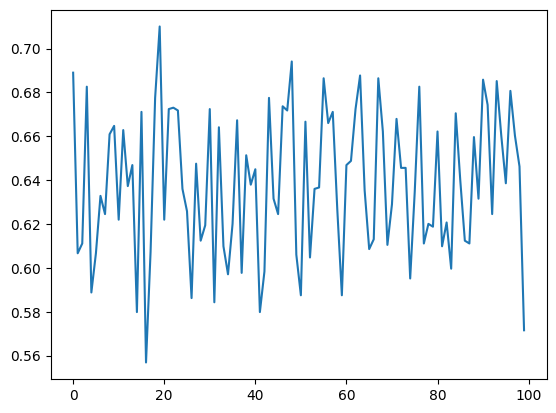

In [9]:
plt.plot(tru)